In [1]:
%matplotlib inline


Classification of age groups using functional connectivity
==========================================================

This example compares different kinds of functional connectivity between
regions of interest : correlation, partial correlation, and tangent space
embedding.

The resulting connectivity coefficients can be used to
discriminate children from adults. In general, the tangent space embedding
**outperforms** the standard correlations: see `Dadi et al 2019
<https://www.sciencedirect.com/science/article/pii/S1053811919301594>`_
for a careful study.


Load brain development fMRI dataset and MSDL atlas
-------------------------------------------------------------------
We study only 30 subjects from the dataset, to save computation time.



In [2]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)

We use probabilistic regions of interest (ROIs) from the MSDL atlas.



In [3]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


C:\Users\adsmith23\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Region signals extraction
-------------------------
To extract regions time series, we instantiate a
:class:`nilearn.input_data.NiftiMapsMasker` object and pass the atlas the
file name to it, as well as filtering band-width and detrending option.



In [4]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

Then we compute region signals and extract useful phenotypic informations.



In [5]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))

Data has 24 children.


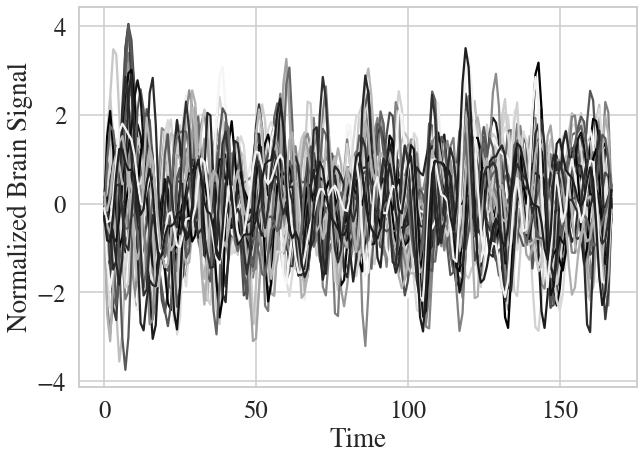

In [9]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.spatial.distance as ds
sns.set()
sns.set_context("talk", font_scale = 1.5)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

color = np.around(np.random.rand(39),decimals = 2)

for i in range(39):
    plt.plot(zscore(time_series)[:,i],c = str(color[i]))

plt.xlabel("Time")

plt.ylabel("Normalized Brain Signal")

plt.savefig("BrainSigs.pdf",transparent = True)

In [7]:
color

array([0.9 , 0.34, 0.89, 0.59, 0.49, 0.08, 0.42, 0.88, 0.19, 0.74, 0.34,
       0.36, 0.22, 0.39, 0.48, 0.59, 0.44, 0.78, 0.74, 0.45, 0.68, 0.01,
       0.23, 0.43, 0.51, 0.01, 0.55, 0.19, 0.73, 0.31, 0.27, 0.29, 0.99,
       0.69, 0.55, 0.01, 0.77, 0.07, 0.78])

ROI-to-ROI correlations of children
-----------------------------------
The simpler and most commonly used kind of connectivity is correlation. It
models the full (marginal) connectivity between pairwise ROIs. We can
estimate it using :class:`nilearn.connectome.ConnectivityMeasure`.



In [16]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

In [17]:
np.shape(pooled_subjects)

(30, 168, 39)

In [18]:
classes

NameError: name 'classes' is not defined

From the list of ROIs time-series for children, the
`correlation_measure` computes individual correlation matrices.



In [19]:
correlation_matrices = correlation_measure.fit_transform(children)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of children are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of children are stacked in an array of shape (24, 39, 39)


In [20]:
corr_mat_all = correlation_measure.fit_transform(pooled_subjects)

In [21]:
tangent_measure = ConnectivityMeasure(kind="precision", vectorize = False)

In [22]:
corr_mat_all = tangent_measure.fit_transform(pooled_subjects)

In [23]:
np.shape(corr_mat_all)

(30, 39, 39)

as well as the average correlation across all fitted subjects.



In [26]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


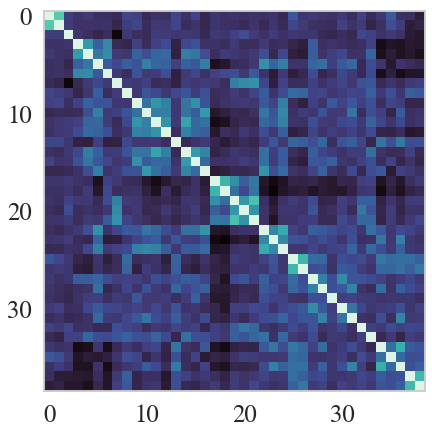

In [56]:
plt.imshow(mean_correlation_matrix,cmap = "mako")
plt.grid(False)

We display the connectome matrices of the first 3 children



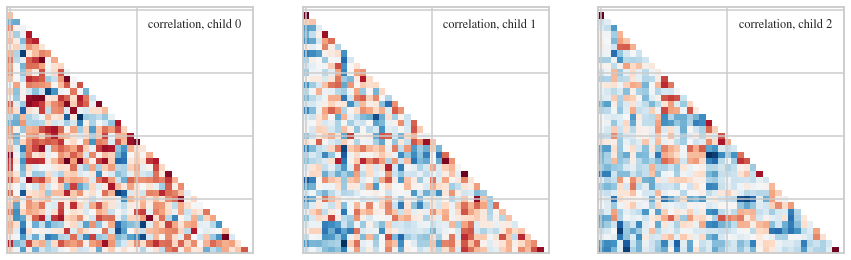

In [27]:
from nilearn import plotting
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='correlation, child {}'.format(i))

The blocks structure that reflect functional networks are visible.



Now we display as a connectome the mean correlation matrix over all children.



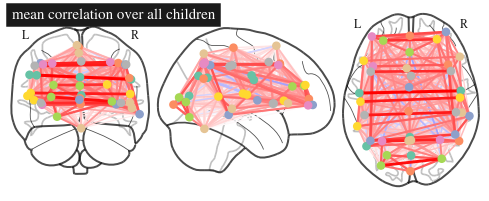

In [28]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over all children')

In [52]:
display = plotting.view_connectome(np.absolute(mean_correlation_matrix), msdl_coords, edge_threshold='70%',colorbar = False, node_size = 6)
display.save_as_html("brain0.html")
# plt.savefig("brain.svg")

Studying partial correlations
-----------------------------
We can also study **direct connections**, revealed by partial correlation
coefficients. We just change the `ConnectivityMeasure` kind



In [58]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    children)

In [62]:
meanpar = np.mean(partial_correlation_matrices,axis = 0)

In [64]:
np.shape(meanpar)

(39, 39)

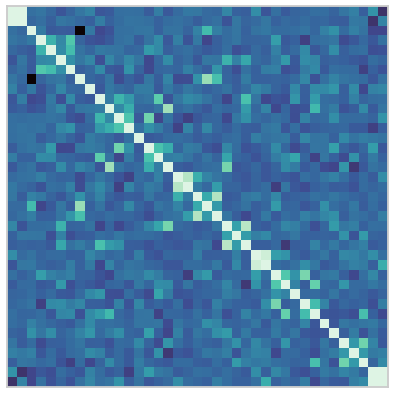

In [76]:
plt.imshow(meanpar,cmap = "mako",vmax = .4)
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig("Partial_Brain.pdf",transparent = True)

Most of direct connections are weaker than full connections.



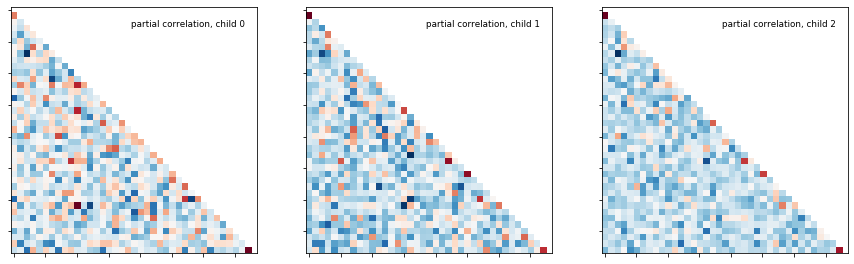

In [12]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='partial correlation, child {}'.format(i))

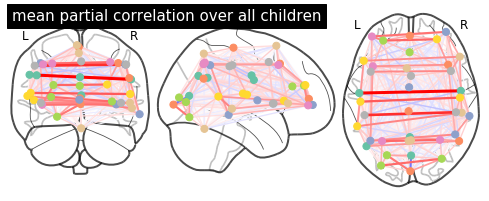

In [13]:
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over all children')

Extract subjects variabilities around a group connectivity
----------------------------------------------------------
We can use **both** correlations and partial correlations to capture
reproducible connectivity patterns at the group-level.
This is done by the tangent space embedding.



In [14]:
tangent_measure = ConnectivityMeasure(kind='tangent')

We fit our children group and get the group connectivity matrix stored as
in `tangent_measure.mean_`, and individual deviation matrices of each subject
from it.



In [15]:
tangent_matrices = tangent_measure.fit_transform(children)

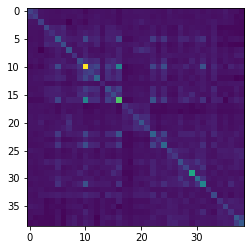

In [24]:
plt.imshow(tangent_measure.)

`tangent_matrices` model individual connectivities as
**perturbations** of the group connectivity matrix `tangent_measure.mean_`.
Keep in mind that these subjects-to-group variability matrices do not
directly reflect individual brain connections. For instance negative
coefficients can not be interpreted as anticorrelated regions.



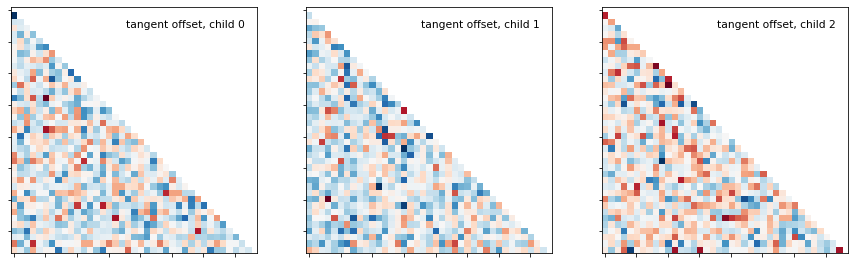

In [16]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='tangent offset, child {}'.format(i))

The average tangent matrix cannot be interpreted, as individual matrices
represent deviations from the mean, which is set to 0.



What kind of connectivity is most powerful for classification?
--------------------------------------------------------------
We will use connectivity matrices as features to distinguish children from
adults. We use cross-validation and measure classification accuracy to
compare the different kinds of connectivity matrices.
We use random splits of the subjects into training/testing sets.
StratifiedShuffleSplit allows preserving the proportion of children in the
test set.



In [106]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import numpy as np

kinds = ['correlation', 'precision', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

display the results



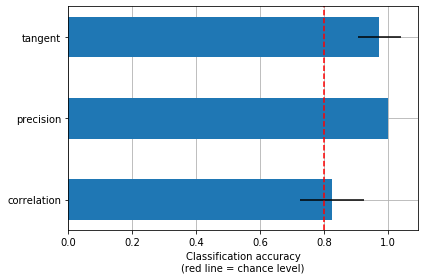

In [107]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

This is a small example to showcase nilearn features. In practice such
comparisons need to be performed on much larger cohorts and several
datasets.
`Dadi et al 2019
<https://www.sciencedirect.com/science/article/pii/S1053811919301594>`_
Showed that across many cohorts and clinical questions, the tangent
kind should be preferred.



In [39]:
np.shape(pooled_subjects)

(30, 168, 39)